In [1]:
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gzip 
import math
import itertools
from time import time
from tqdm import tqdm
import tqdm.notebook as tq
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os
import vec_tools
import word_tools
import statistics
from nltk.corpus import stopwords
import random
from scipy.stats import pearsonr

In [11]:
#Managers, officials, and proprietors (nec),"manager, official, proprietor"
def corr_census(self, models, tag_words):

    occ_map = pd.read_csv("G:/My Drive/KU/Thesis/data/garg/occupation_map.csv", index_col="Occupation, 1950 basis").to_dict()["Single words"]
    occs = {v: k for k, v in occ_map.items() if type(v) != list}
    capitals = {"EDUC":"Education", "PRESGL":"Status", "INCTOT":"Affluence"}
    cats = capitals.values()
    capitals = {v: k for k, v in capitals.items()}

    ant_pairs = {}
    vals = {}
    projs = {}
    dims = {}
    self.vals = {}

    for cat in cats:
        print(cat)
        vals[cat + "_survey"] = {}
        vals[cat + "_proj"] = {}
        #print(domain, cat)
        ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
        ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
        #prepare dictionaries for survey & projection values
        #calculate dimensions from antonym pairs
        for dec, model in models.items():
            survey = pd.read_csv(f"G:/My Drive/KU/Thesis/data/us_census/census_{dec}_OCC1950.csv", index_col = 0)
            embed = self.models[model]
            dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
            #project embeddings onto dimension
            projs[cat] = self.proj_dim(model, dims[cat])
            #iterate through words
            not_in_vocab = []
            for index, row in survey.iterrows():
                #print(index, row)try:
                try:
                    occ_cat = row.name
                    if occ_cat != tag_words:
                        continue
                    occ_spl = occ_map[ "Managers, officials, and proprietors (nec)"].lower().split()
                #    print(occ_spl)
                    w_projs = []
                    for w in occ_spl:
                     #   print(w)
                        if w == "nan":
                            continue
                        if w[-1] == ",":
                            w = w[:-1]
                       # if w not in tag_words: FOR TAG WORDS
                        #    continue
                        try:
                            ind = embed.get_index(w)
                            proj = projs[cat][ind]
                        except Exception as e:
                            print(e)
                            continue
                        if proj != proj:
                            continue
                        w_projs.append(proj)
                    #    print(row.name, w_projs)
                        val = np.mean(w_projs)
                        #add all to DF
                        vals[cat + "_survey"][dec] = row[capitals[cat] + "_mean"]
                        vals[cat + "_proj"][dec] = val
                except Exception as e:
                    print(e)
                    pass
                    #not_in_vocab.append(word)

         #   print(f"{not_in_vocab} not in embeddings vocab!")
    self.vals = pd.DataFrame(vals)
    corrs = {}
    print(vals)
    for cat in cats:
       # print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
        corrs[cat + "_survey_corr"] = pearsonr(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
        #corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
    return corrs
coll = "histwords_engall"
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=False, dl=False)
for fil in decade_files:
    eval_iter.load_wv(fil)
decade_dic = {str(1950+10*i):str(1900+10*i) +'_model' for i in range(5)}

AttributeError: Model of type <class 'gensim.models.keyedvectors.KeyedVectors'> can't be loaded by <class 'gensim.models.word2vec.Word2Vec'>

In [68]:
#words = ["manager", "official", "proprietor"]

tag_cat = "Managers, officials, and proprietors (n.e.c.)"
corr_census(eval_iter, decade_dic, tag_cat)

Education
Status
Affluence
{'Education_survey': {'1950': 5.194494654720726, '1960': 5.756920712201364, '1970': 6.377378593592284, '1980': 7.256962381510368, '1990': 7.625159258033125}, 'Education_proj': {'1950': -0.019532956, '1960': 0.024135066, '1970': 0.00064191717, '1980': -0.023825215, '1990': 0.04703392}, 'Status_survey': {'1950': 50.3, '1960': 50.3, '1970': 50.3, '1980': 50.3, '1990': 50.299999999983925}, 'Status_proj': {'1950': 0.044436965, '1960': 0.07762253, '1970': 0.08586442, '1980': 0.066675, '1990': 0.054849464}, 'Affluence_survey': {'1950': 3931.358263833244, '1960': 7227.723284646474, '1970': 11486.845769935324, '1980': 20036.61410493866, '1990': 36930.26084695894}, 'Affluence_proj': {'1950': -0.021019913, '1960': -0.0052005234, '1970': 0.03460068, '1980': -0.01730617, '1990': -0.011985395}}


{'Education_survey_corr': (0.3634832621272771, 0.5476017825405834),
 'Status_survey_corr': (0.36893098512792577, 0.5411473752237153),
 'Affluence_survey_corr': (-0.1509158375665935, 0.8085798959525343)}

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Status_survey', ylabel='Status_proj'>

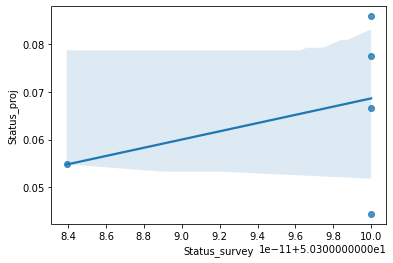

In [77]:
import seaborn as sns
#print(eval_coha.vals)
dim = "Status"
sns.regplot(eval_iter.vals[f"{dim}_survey"],eval_iter.vals[f"{dim}_proj"])
#sns.regplot(eval_coha.vals["activities"]["affluence_survey"],eval_coha.vals["activities"]["affluence_proj"])
#eval_coha.vals["music"].plot.scatter(x="affluence_survey",y="affluence_proj")

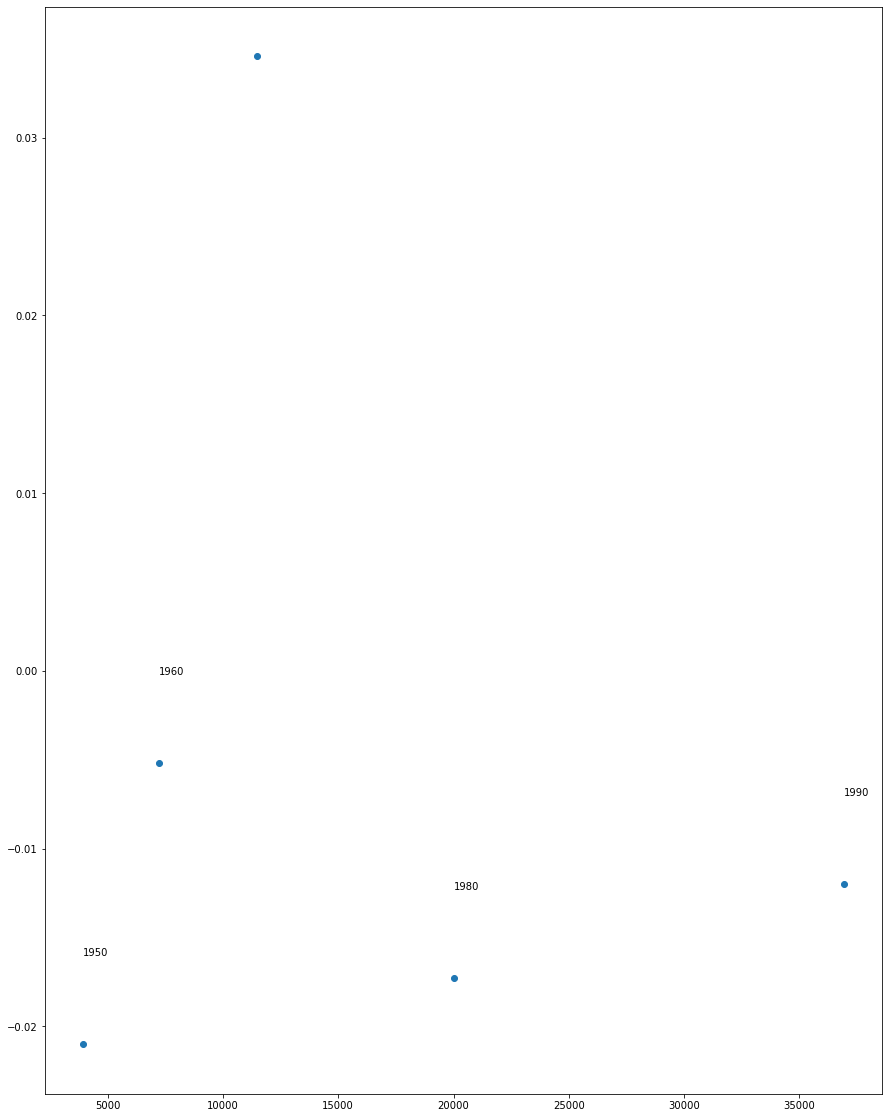

In [74]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(figsize=(15,20))
surv = eval_iter.vals[f'{dim}_survey']
proj = eval_iter.vals[f'{dim}_proj']
#sns.scatterplot(data=eval_coha.vals,x='Affluence_survey', y="Affluence_proj")
plt.scatter(surv, proj)
# Annotate label points 
drift = (0.05,0.005)#status(1, 0.005)#aff(50, 0.005) 
for i, occ in enumerate (eval_iter.vals.index):
    plt.annotate(occ, (surv[i]+drift[0], proj[i]+drift[1]) )
#eval_coha.vals.plot.scatter(x="Affluence_survey",y="Affluence_proj"

In [55]:
for i in pd.read_csv("G:/My Drive/KU/Thesis/data/garg/occupation_map.csv", index_col="Occupation, 1950 basis").to_dict()["Single words"].keys():
    print(i)
    

Dyers
Bakers
Inmate
Sawyers
Retired
Porters
Authors
Cashiers
Newsboys
Chemists
Dentists
Glaziers
Furriers
Athletes
Midwives
Draftsmen
Designers
Clergymen
Teamsters
Surveyors
Milliners
Carpenters
Machinists
Bartenders
Librarians
Economists
Architects
Credit men
Plasterers
Physicists
Bootblacks
Osteopaths
N/A (blank)
Bookkeepers
Bus drivers
Blacksmiths
Pharmacists
Millwrights
Bookbinders
Postmasters
Loom fixers
Auctioneers
Electricians
Bank tellers
Agents (nec)
Upholsterers
Farm foremen
Boilermakers
Optometrists
Paperhangers
Foremen (nec)
Mail carriers
Farm managers
Photographers
Psychologists
Demonstrators
Cabinetmakers
Chiropractors
Veterinarians
Laborers (nec)
Molders, metal
Heaters, metal
Mathematicians
Engineers (nec)
Civil-Engineers
Radio operators
Practical nurses
Inspectors (nec)
Weavers, textile
Mining-Engineers
Teachers (n.e.c.)
At school/student
Technicians (nec)
Religious workers
Spinners, textile
Lawyers and judges
Stationary firemen
Job setters, metal
Entertainers (nec)
Bra

# Create/load domains

In [3]:
lst_dir =  "G:/My Drive/KU/Thesis/data/domains/" 
domain_dic = {}

garg_lists = ["occupations1950.txt", "adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt', 'occupations1950_professional.txt']

for dic in garg_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/garg/{dic}", encoding="utf-8").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]

wiki_lists = ['sports','music_genres','lit_genres','us_cities','uk_cities',
               'countries','art_movs','hobbies','subcultures'] 
for lst in wiki_lists:
    domain_dic[lst] = word_tools.load_list(f"{lst_dir}/wiki/{lst}_wiki.txt")
    
manual_lists = [ 'virtues.txt', 'vices.txt', 'genres.txt', 'emotions.txt', 'housing.txt',
 'clothing.txt', 'white_trash.txt', 'old_rich.txt', 'new_rich.txt', 'u.txt', 'new_u.txt', 'non_u.txt',
 'refined.txt', 'unrefined.txt']

for dic in manual_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/domains/{dic}").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]
domain_dic.keys()

domain_dic["goc_genres"] = ["hiphop", "rap", "bluegrass", "opera", "jazz", "techno", "punk"]

In [4]:
groups =['Iso_occupations.xlsx','standard_occupations_uk_incomplete.xlsx','occupations_1950_categorised.xlsx','vices_virtues.xlsx','u_non_u.xlsx','old_rich_new_rich.xlsx','emerging_traditional_genres.xlsx']
os.chdir("G:/My Drive/KU/Thesis/data/domains/dicts/")
os.listdir()
for group in groups: 
    domain_dic[group[:-5]] = vec_tools.load_domain_dic(f"G:/My Drive/KU/Thesis/data/domains/dicts/{group}")
   

# Almighty iterator

In [5]:
coll = "histwords_engall"#"gb_12_18_02"#
#input_dir = f"D:/google_ngrams/vectors/{coll}"
dims = ["affluence", "cultivation", "status", "gender", "race", "morality", "education"]
histwords_iter = vec_tools.AllDecsIterator(coll, dims, kv=True, test=False)
histwords_iter.iterate()

coll = "gb_12_18_02"
#gb_12_iter = vec_tools.AllDecsIterator(coll, dims, kv=False, test=False)
#gb_12_iter.iterate()
#dists = iterator.stability_through_time()
#iterator.avg_distance(n=50)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
G:\My Drive\KU\Thesis\vec_tools.py:152: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot)


# Validation

In [8]:
coll = "histwords_engall"#"gb_12_18_02"#
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
#input_dir = f"D:/google_ngrams/vectors/{coll}"
dims = ["affluence", "cultivation", "status", "gender", "race", "morality", "education"]
histwords_iter = vec_tools.AllDecsIterator(coll, dims, kv=True, test=False)
histwords_iter.iterate()

#coll = "gb_12_18_02"
#print(eval_coha.vals)
#gb_12_iter = vec_tools.AllDecsIterator(coll, dims, kv=False, test=False)
#gb_12_iter.iterate()
#dists = iterator.stability_through_time()
#iterator.avg_distance(n=50)

NameError: name 'vec_tools' is not defined

In [23]:
#Managers, officials, and proprietors (nec),"manager, official, proprietor"
 def corr_census(self, models, tag_word):
                           
        occ_map = pd.read_csv("G:/My Drive/KU/Thesis/data/garg/occupation_map.csv", index_col="Occupation, 1950 basis").to_dict()["Single words"]
        occs = {v: k for k, v in occ_map.items() if type(v) != list}
        capitals = {"EDUC":"Education", "PRESGL":"Status", "INCTOT":"Affluence"}
        cats = capitals.values()
        capitals = {v: k for k, v in capitals.items()}

        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        self.vals = {}

        for cat in cats:
            vals[cat + "_survey"] = {}
            vals[cat + "_proj"] = {}
            #print(domain, cat)
            ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
            ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
            #prepare dictionaries for survey & projection values
            #calculate dimensions from antonym pairs
            for dec, model in models.items():
                survey = pd.read_csv(f"G:/My Drive/KU/Thesis/data/us_census/census_{dec}_OCC1950.csv", index_col = 0)
                embed = self.models[model]
                dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
                #project embeddings onto dimension
                projs[cat] = self.proj_dim(model, dims[cat])
                #iterate through words
                not_in_vocab = []
                for index, row in survey.iterrows():
                    #print(index, row)try:
                    try:
                        word = occ_map[row.name].lower()
                        if word != tag_word:
                            continue
                        #print(word)
                        #retrieve index in embeddings
                        ind = embed.get_index(word)
                        #retrieve projected value using index
                        val = projs[cat][ind]
                        #add all to DF
                        vals[cat + "_survey"][dec] = row[capitals[cat] + "_mean"]
                        vals[cat + "_proj"][dec] = val
                    except Exception as e:
                        pass
                        #not_in_vocab.append(word)

             #   print(f"{not_in_vocab} not in embeddings vocab!")
            self.vals = pd.DataFrame(vals)
            corrs = {}
            for cat in cats:
                print(vals)
               # print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
                corrs[cat + "_survey_corr"] = pearsonr(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
                #corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
            return corrs
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=False, dl=False)
 for fil in decade_files:
    eval_iter.load_wv(fil)
decade_dic = {str(1950+10*i):str(1900+10*i) +'_model' for i in range(5)}
corr_census(eval_iter, decade_dic, "manager")

{'Education_survey': {}, 'Education_proj': {}}


ValueError: x and y must have length at least 2.

In [ ]:
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=False, dl=False)
eval_iter.load_wv(decade_files[-1])
print(eval_iter.corr_census(decade_files[-1]))

In [ ]:
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=False, dl=False)
census_corrs = {}
for dec in decade_files:
    eval_iter.load_wv(dec)
    census_corrs[dec] = eval_iter.corr_census(dec)
pd.DataFrame(census_corrs)

## Stereotype through time

In [9]:
managers = ["executive", "manager", "director", "leader", "president", "boss", "chief", "ceo", "superintendent","foreman"]
u = ["consultant", "adviser", "advisor", "customer", "entrepreneur", "expert"]
ns_words = ["network", "networks", "networking", 
         "innovation", "innovative", "innovate", "create", "creative", "creativity", 
         "inspiration", "inspire", "inspirational", "genius", "invent", "inventor", 
         "disruptive", "bureaucracy", "bureaucrat", "decentralized",
         'decentralization','meritocracy','objectives','cadres','networks','project','vision', #projective city
          'streamlined','slimmed','lean','leader','reengineering','flexible','innovative', "communicative",
          'proficient','coach','catalyst','visionary','inspiration','inspire', 'expert','operatives',
          'toyota','ford', 'outward','fulfilment','autonomy','discovery','enrichment','learning','spontaneity',
          'spectacle','reticular','alliance',
         'Engaged','Engaging','Mobile','Enthusiastic','Involved','Flexible', #cond great man
         'Adaptable','Versatile','Employable','Autonomous','Tolerant']
ns_terms = ['CEO', 'Project', 'Team', "Network", "Networks", 'Networking', 'Decentralized', 'Decentralization',
            'Disruptive', 'Lean', 'Catalyst']
ns_traits = ['Engaged','Engaging','Mobile','Enthusiastic','Involved','Flexible', #cond great man
         'Adaptable','Versatile','Autonomous','Tolerant', 'Communicative',
         'Spontaneity', 'Inspiring', 'Inspirational','Flexible', 'Innovative', 'Creative',
            'Vision', 'Genius', 'Entrepreneur']
["adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt'] #example domains

['adjectives_appearance.txt',
 'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt',
 'adjectives_otherization.txt',
 'adjectives_princeton.txt',
 'adjectives_sensitive.txt',
 'adjectives_williamsbest.csv',
 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt']

# General stereotype through time

In [6]:
#STEREOTYPE THROUGH TIME
# EACH MANAGERIAL WORD, 
occ = "manager"
wl = domain_dic["personalitytraits_original"]# domain_dic["vices"] + domain_dic["virtues"]
histwords_iter.stereotype_through_time(occ, word_list=wl, type="word_list",inc_val=True, select="a", selectn=10, topn= 5000)
histwords_iter.stereotypes[occ]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990
0,"(responsible, 0.255)","(cooperative, 0.285)","(cooperative, 0.232)","(athletic, 0.272)","(responsible, 0.224)","(cooperative, 0.208)","(responsible, 0.175)","(responsible, 0.288)","(helpful, 0.205)","(responsible, 0.207)"
1,"(confidential, 0.202)","(confidential, 0.225)","(responsible, 0.228)","(grand, 0.254)","(cooperative, 0.215)","(responsible, 0.197)","(cooperative, 0.164)","(efficient, 0.165)","(responsible, 0.202)","(intelligent, 0.163)"
2,"(private, 0.189)","(grand, 0.222)","(confidential, 0.217)","(cooperative, 0.241)","(grand, 0.14)","(athletic, 0.178)","(private, 0.147)","(private, 0.158)","(working, 0.163)","(regimental, 0.161)"
3,"(grand, 0.179)","(athletic, 0.216)","(athletic, 0.199)","(responsible, 0.213)","(skillful, 0.13)","(confidential, 0.134)","(moody, 0.146)","(cooperative, 0.151)","(directed, 0.155)","(shrewd, 0.158)"
4,"(cooperative, 0.174)","(responsible, 0.201)","(grand, 0.163)","(protective, 0.141)","(organized, 0.125)","(grand, 0.134)","(sage, 0.144)","(directed, 0.145)","(cooperative, 0.138)","(circumspect, 0.155)"
5,"(retiring, 0.163)","(skillful, 0.171)","(skillful, 0.14)","(private, 0.136)","(athletic, 0.122)","(bland, 0.127)","(enthusiastic, 0.13)","(regimental, 0.136)","(prudent, 0.133)","(athletic, 0.141)"
6,"(moody, 0.153)","(organized, 0.146)","(organized, 0.136)","(helpful, 0.128)","(protective, 0.12)","(independent, 0.117)","(regimental, 0.122)","(difficult, 0.134)","(busy, 0.132)","(prudent, 0.14)"
7,"(skillful, 0.146)","(active, 0.14)","(efficient, 0.131)","(sporting, 0.126)","(enthusiastic, 0.119)","(private, 0.114)","(difficult, 0.118)","(confidential, 0.131)","(efficient, 0.131)","(active, 0.134)"
8,"(outspoken, 0.14)","(shrewd, 0.135)","(providential, 0.119)","(enthusiastic, 0.125)","(irresponsible, 0.118)","(regimental, 0.113)","(competitive, 0.117)","(athletic, 0.127)","(private, 0.116)","(sharing, 0.134)"
9,"(shrewd, 0.13)","(regimental, 0.128)","(private, 0.117)","(benevolent, 0.123)","(efficient, 0.114)","(working, 0.112)","(athletic, 0.113)","(grand, 0.122)","(tough, 0.112)","(skillful, 0.132)"


In [16]:
histwords_iter.stereotype_through_time("network", word_list=ns_words, type="tag",inc_val=True, select="a", selectn=30, topn= 5000)
histwords_iter.stereotypes["network"]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning:

invalid value encountered in true_divide



,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990
0,"(capillary, 0.42425528168678284)","(vascular, 0.4470035433769226)","(vascular, 0.40223902463912964)","(vascular, 0.40129169821739197)","(concentric, 0.3418092429637909)","(lymphatic, 0.3215101361274719)","(connected, 0.37550920248031616)","(noncommercial, 0.33748871088027954)","(broadband, 0.5188156366348267)","(broadband, 0.38722550868988037)"
1,"(vascular, 0.42345762252807617)","(concentric, 0.3893994987010956)","(concentric, 0.39090073108673096)","(concentric, 0.3823862671852112)","(terminal, 0.33837565779685974)","(connected, 0.3172723054885864)","(terminal, 0.33753979206085205)","(integrated, 0.3024905025959015)","(connected, 0.38315683603286743)","(neural, 0.35016554594039917)"
2,"(continuous, 0.3814805746078491)","(areolar, 0.38047492504119873)","(capillary, 0.3339206874370575)","(capillary, 0.32656192779541016)","(connected, 0.31750696897506714)","(continuous, 0.3153374195098877)","(concentric, 0.3298789858818054)","(interactive, 0.2891348898410797)","(integrated, 0.3437917232513428)","(connected, 0.32522183656692505)"
3,"(areolar, 0.3662044405937195)","(capillary, 0.372184157371521)","(tangled, 0.33243879675865173)","(lymphatic, 0.3230251669883728)","(vascular, 0.3077923655509949)","(vascular, 0.3121626377105713)","(complex, 0.32292497158050537)","(lymphatic, 0.27306127548217773)","(hierarchical, 0.29933232069015503)","(wireless, 0.3164057433605194)"
4,"(concentric, 0.36538028717041016)","(synovial, 0.35833221673965454)","(bordered, 0.30243849754333496)","(complex, 0.3142770528793335)","(lymphatic, 0.3004027307033539)","(afferent, 0.30467063188552856)","(dimensional, 0.3084968626499176)","(continuous, 0.2714442014694214)","(digital, 0.27945220470428467)","(integrated, 0.3071404695510864)"
5,"(lined, 0.3650725781917572)","(lymphatic, 0.3453976511955261)","(complex, 0.2998179793357849)","(symmetrical, 0.3061324954032898)","(postal, 0.2914882302284241)","(concentric, 0.29051274061203003)","(capillary, 0.2964090406894684)","(connected, 0.26984095573425293)","(interactive, 0.27559739351272583)","(digital, 0.3045113682746887)"
6,"(tendinous, 0.36362791061401367)","(tangled, 0.345083624124527)","(covered, 0.2923416197299957)","(extensive, 0.30010199546813965)","(resistive, 0.2672995328903198)","(integrated, 0.2889077067375183)","(symmetrical, 0.28776025772094727)","(terminal, 0.26684656739234924)","(terminal, 0.26932573318481445)","(wired, 0.296182781457901)"
7,"(thin, 0.36248061060905457)","(cellular, 0.3414367139339447)","(endothelial, 0.2920488119125366)","(reticular, 0.2884998321533203)","(capillary, 0.26531052589416504)","(terminal, 0.28608232736587524)","(collagenous, 0.28729093074798584)","(structured, 0.2625396251678467)","(binary, 0.2671668529510498)","(local, 0.2894916534423828)"
8,"(cellular, 0.35261544585227966)","(woven, 0.3222469091415405)","(woven, 0.27492836117744446)","(endothelial, 0.285146027803421)","(electronic, 0.26461851596832275)","(sensory, 0.285223126411438)","(linear, 0.2827647924423218)","(operational, 0.2613638639450073)","(local, 0.26712340116500854)","(mobile, 0.2836266756057739)"
9,"(tangled, 0.3505362272262573)","(reticular, 0.32107171416282654)","(granular, 0.2741282880306244)","(arterial, 0.278048038482666)","(aerial, 0.2631651759147644)","(reticular, 0.27152082324028015)","(voltaic, 0.2750869393348694)","(extensive, 0.26056352257728577)","(structured, 0.2559591233730316)","(hierarchical, 0.28147876262664795)"


In [34]:
histwords_iter.stereotype_through_time("network", word_list=ns_words, type="word_list",inc_val=True, select="a", selectn=30, topn= 5000)
histwords_iter.stereotypes["network"]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning:

invalid value encountered in true_divide



,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990
0,"(flexible, 0.259)","(reticular, 0.321)","(reticular, 0.255)","(networks, 0.37)","(networks, 0.424)","(networks, 0.543)","(networks, 0.575)","(networks, 0.59)","(networks, 0.646)","(networks, 0.698)"
1,"(objectives, 0.145)","(flexible, 0.27)","(flexible, 0.211)","(reticular, 0.288)","(reticular, 0.219)","(reticular, 0.272)","(reticular, 0.27)","(reticular, 0.241)","(reticular, 0.251)","(networking, 0.432)"
2,,"(bureaucracy, 0.123)","(bureaucracy, 0.134)","(flexible, 0.27)","(flexible, 0.213)","(operatives, 0.194)","(operatives, 0.212)","(project, 0.212)","(networking, 0.234)","(decentralized, 0.243)"
3,,"(autonomy, 0.122)","(create, 0.119)","(operatives, 0.17)","(operatives, 0.173)","(decentralized, 0.175)","(decentralized, 0.178)","(operatives, 0.211)","(operatives, 0.212)","(reticular, 0.213)"
4,,,"(operatives, 0.111)","(enrichment, 0.133)","(create, 0.105)","(create, 0.172)","(bureaucracy, 0.161)","(decentralized, 0.179)","(innovative, 0.182)","(innovative, 0.189)"
5,,,,"(catalyst, 0.129)","(enrichment, 0.105)","(bureaucracy, 0.125)","(create, 0.149)","(create, 0.16)","(create, 0.179)","(bureaucracy, 0.172)"
6,,,,"(decentralization, 0.108)",,"(flexible, 0.12)","(project, 0.136)","(flexible, 0.139)","(flexible, 0.164)","(expert, 0.165)"
7,,,,"(create, 0.089)",,"(coach, 0.096)","(flexible, 0.132)","(bureaucracy, 0.11)","(decentralized, 0.147)","(innovation, 0.159)"
8,,,,,,,"(decentralization, 0.126)","(innovative, 0.108)","(project, 0.143)","(create, 0.155)"
9,,,,,,,"(innovation, 0.101)","(communicative, 0.101)","(alliance, 0.139)","(project, 0.149)"


# Distance between manager and other words through time

G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


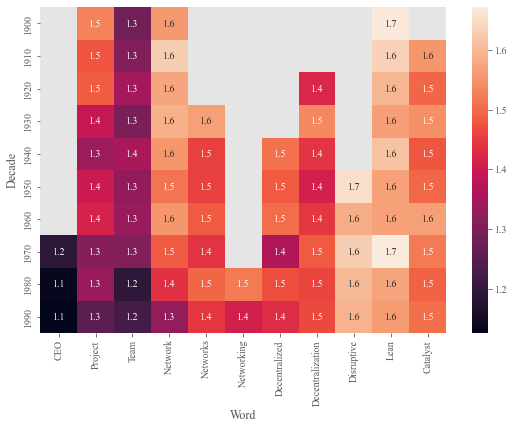

In [57]:
#ANGLES
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

#different words for manager
#Specific ns words like team, project, etc

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
wl = ns_terms
distance_dic = {word: {} for word in wl}
for word in wl:
    for dec, wv in histwords_iter.wvs.items():
        try:
            distance_dic[word][dec] = vec_tools.vector_angle(wv["manager"], wv[word.lower()])
        except:
            continue
       # print(dec, vec_tools.vector_angle(wv["manager"], wv["project"]))
#print(pd.DataFrame(distance_dic).round(3).replace(np.nan, "N/A").T.to_latex())
fig, ax = plt.subplots(figsize = (9.094437525944375,6))#(6.062958350629584, 3.747114333064086))
plt.style.use("ggplot")
df = pd.DataFrame(distance_dic).rename_axis("Word", axis=1)
df.index.names = ["Decade"]
sns.heatmap(df, annot=True)
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/heatmap_terms.jpg", dpi=400, bbox_inches = "tight")

# Calculate word space contraction/expansion over time

In [9]:
ns_constants = []
ns_words = ["project", "team", "manager", "flexible", "inspiration", "network"]

for word in ns_words:
    for dec, wv in histwords_iter.wvs.items():
        if dec == "1990":
            try:
                wv[word.lower()]
                ns_constants.append(word)
            except:
                break
        try:
            print(wv[word.lower()])
            wv[word.lower()]
        except:
            print(word)
            break
print(ns_constants)
for dec, wv in histwords_iter.wvs.items():
    dist = vec_tools.measure_word_space(wv, norm_matrix="", word_list=ns_constants)
    print(dec, dist)

[-0.0960055   0.04671398 -0.02031473 -0.03345393  0.00127444  0.09868728
  0.01226073  0.08856596 -0.10869482  0.10175785 -0.00572136 -0.02638988
 -0.08846582  0.02689752  0.01375816 -0.08568317 -0.0378221   0.00287028
 -0.08654931 -0.0047047   0.00025803 -0.01999075  0.03983358  0.00813658
  0.04991126  0.0243999   0.01589614  0.03070801  0.04695916 -0.04622917
  0.01705556 -0.15636519  0.16055526  0.06523779  0.03100997 -0.03564465
 -0.07832502  0.09176232 -0.09070376 -0.05292758 -0.11417723 -0.02591898
 -0.01881414 -0.03102162 -0.00816433 -0.00836845 -0.0142124   0.04221852
  0.09620563  0.11494105 -0.05675369 -0.04044564 -0.0888628  -0.02107835
  0.05900429  0.07767043  0.09950069  0.11211812 -0.04992187 -0.01821778
 -0.00454786 -0.02087604 -0.00798818 -0.03981981 -0.02238894 -0.06359793
 -0.08210909  0.05165244 -0.0770273   0.05312131  0.03201544 -0.0325945
  0.00932946 -0.03549599 -0.05036625  0.01299694  0.07745262  0.05630045
 -0.06417225  0.04155742 -0.1160522   0.09357796 -0.

[ 6.21667244e-02 -1.39617696e-02  1.08173862e-01 -4.71593738e-02
  1.39858425e-02  7.80006871e-02  3.57694644e-03 -3.09673473e-02
  8.43970850e-02  2.25432459e-02 -9.13185161e-03 -7.51943588e-02
 -1.41436961e-02  1.13038905e-01 -1.23657947e-02  2.22112965e-02
  8.09971541e-02  6.56303242e-02 -5.72063476e-02 -3.30969109e-03
  2.24799514e-02  1.04699962e-01  7.16519505e-02  4.87296283e-02
 -8.44152048e-02 -2.72838008e-02 -3.84038463e-02 -7.16990232e-02
  5.39406389e-02 -6.84624724e-03 -5.73242679e-02 -5.97392395e-02
 -8.69930834e-02  3.21546197e-02  5.90815581e-02  5.74485846e-02
 -2.85850503e-02  3.27369459e-02 -3.46084908e-02  3.12176440e-02
 -2.08586864e-02  3.68418582e-02 -3.23363058e-02 -5.47312433e-03
  6.85565174e-02  2.41212957e-02  6.11691475e-02 -4.02072305e-03
  8.34827498e-02  3.23971026e-02  4.62383553e-02 -4.09758389e-02
 -2.35570278e-02  5.33633418e-02  3.84965390e-02  4.75265086e-03
 -8.15285891e-02 -4.80874181e-02  7.35717043e-02  9.30406079e-02
  1.39779136e-01  6.34883

# Line graph

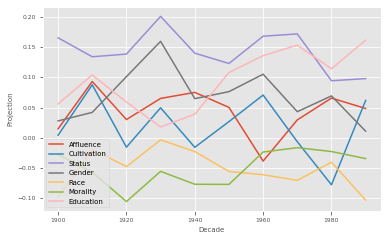

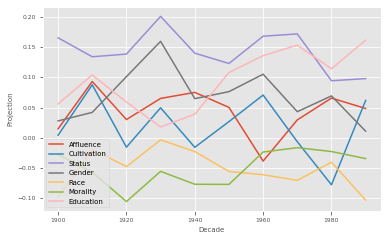

In [7]:
wlist = ["manager"]
def aggregate_word_line_graph(class_obj, wlist): #Can also be used for a single word if that single word is a single element in a list
    wlist_projs  = {dim.title(): {dec: [] for dec, wv in class_obj.wvs.items()} for dim in class_obj.dims}
    word_projs = {dim: {} for dim in class_obj.dims}
    for dec, wv in class_obj.wvs.items():
        for dim in class_obj.dims:
            for word in wlist: 
                try:
                    ind = wv.get_index(word.lower())
                except:
                    continue
                proj = class_obj.projs[dec][dim][ind]
                if pd.isna(proj):
                    continue
                wlist_projs[dim.title()][dec].append(proj)
               # print(dec, dim, word, proj)
            wlist_projs[dim.title()][dec] = np.mean(wlist_projs[dim.title()][dec])
            try:
                ind = wv.get_index(word.lower())
            except:
                continue
            proj = class_obj.projs[dec][dim][ind]
            word_projs[dim][dec] = proj
    df = pd.DataFrame(wlist_projs)
    fig, ax = plt.subplots(figsize=((6.062958350629584, 3.747114333064086)))
    ax.set_xlabel("Decade", fontsize=7)
    ax.set_ylabel("Projection", fontsize=7)
    ax.tick_params(axis='x',labelsize=6, zorder=1)
    ax.tick_params(axis='y',labelsize=6, zorder=1)
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (6.062958350629584, 3.747114333064086)
    df.plot.line(ax=ax)
    #plt.xticks([1900+10*i for i in range(10)])
    plt.legend(loc="lower left", fontsize=7)
aggregate_word_line_graph(histwords_iter, wlist)
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/manager_line.jpg", dpi=400, bbox_inches = "tight")

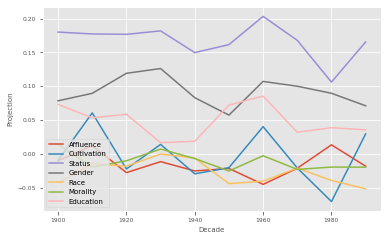

In [10]:
wlist = managers
aggregate_word_line_graph(histwords_iter, wlist)
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/managers_line.jpg", dpi=400, bbox_inches = "tight")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


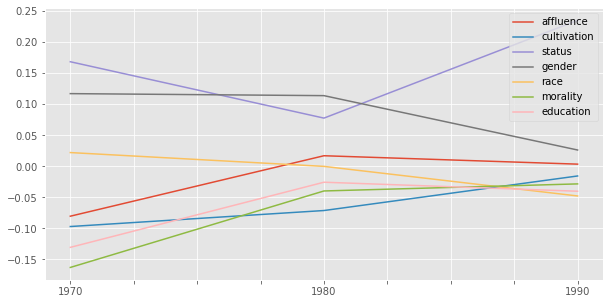

In [11]:
wlist = ["CEO"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

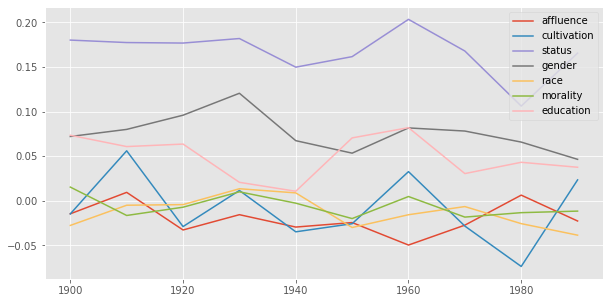

In [1]:
managers

NameError: name 'managers' is not defined

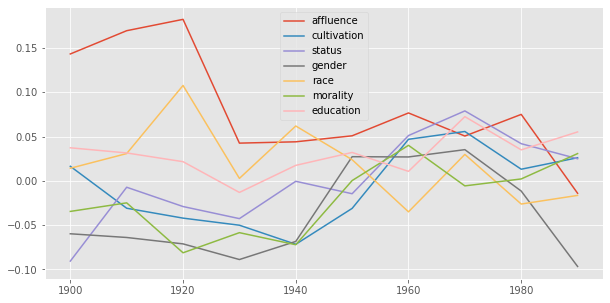

In [13]:
wlist = ["network"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

# Polar graph

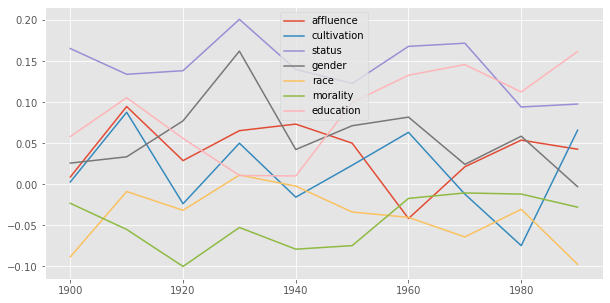

In [14]:
vec_tools.polar_chart(histwords_iter, ["manager"])

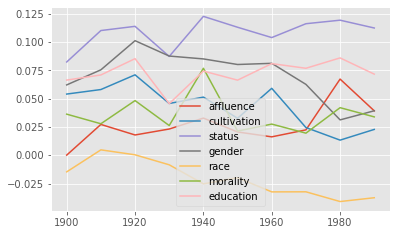

In [45]:
self = histwords_iter
wlist = domain_dic["Iso_occupations"]["Professional"]
wlist_projs  = {dim: {dec: [] for dec, wv in self.wvs.items()} for dim in self.dims}
word_projs = {dim: {} for dim in self.dims}
for dec, wv in self.wvs.items():
    for dim in self.dims:
        for word in wlist: 
            ind = wv.get_index(word.lower())
            proj = self.projs[dec][dim][ind]
            if pd.isna(proj):
                continue
            wlist_projs[dim][dec].append(proj)
           # print(dec, dim, word, proj)
        wlist_projs[dim][dec] = np.mean(wlist_projs[dim][dec])
        ind = wv.get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[dim][dec] = proj
df = pd.DataFrame(wlist_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (6.062958350629584, 3.747114333064086)
df.plot.line()
df.unstack()
n = pd.DataFrame(df.stack()).reset_index()
n.columns = ["Decade", "Dimension", "Projection"]
px.line_polar(n, r="Projection", theta="Dimension", color="Decade", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="ggplot2",)

In [26]:
domain_dic["Iso_occupations"].keys()

dict_keys(['Managers', 'Professional', 'Technicians and associate professionals', 'Clerical support workers', 'Service and sales workers', 'Skilled agricultural, forestry and fishery workers', 'Craft and related trades ', 'Plant and machine operators, and assemblers', 'Elementary occupations', 'Armed forces occupations'])

In [ ]:
domain

In [58]:
both = pd.concat([manager, professions], axis=1, keys = ("Manager", "Professions"))
both.index = ["Affluence", "Cultivation", "Status", "Gender", "Race", "Morality", "Education"]
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (6.062958350629584, 3.747114333064086)

df.unstack()
n = pd.DataFrame(both.stack()).reset_index()
n.columns = ["Dimension", "Occupation", "Projection"]

fig = px.line_polar(n, r="Projection", theta="Dimension", color="Occupation", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Bold,
                    template="ggplot2",)
fig.update_layout(
    margin=dict(l=10, r=10, t=30, b=20),
               font_family="Times New Ronan",

)
#plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/manager_prof_polar.jpg", dpi=400, bbox_inches = "tight")
fig.write_image("G:/My Drive/KU/Thesis/outputs/graphs/manager_prof_polar.jpg")

In [41]:
n

,Dimension,Occupation,Projection
0,Affluence,Manager,0.048393
1,Affluence,Professions,0.039308
2,Cultivation,Manager,0.061709
3,Cultivation,Professions,0.022899
4,Status,Manager,0.097933
5,Status,Professions,0.112555
6,Gender,Manager,0.010711
7,Gender,Professions,0.039374
8,Race,Manager,-0.103522
9,Race,Professions,-0.037495


In [15]:
px.line_polar(n, r="Projection", theta="Dimension", color="Decade", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="ggplot2",)

# 1900-1990 comparison

In [ ]:
#line graph
word_list = domain_dic["occupations1950"][:7]
word_projs = {word: {} for word in word_list}
year_1, year_2 = ["1900", "1990"]
dim = "affluence"

for dec in [year_1, year_2]:
    for word in word_list:
        ind = self.wvs[dec].get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[word][dec] = proj
df = pd.DataFrame(word_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
#df.unstack()

In [14]:
#polar graph *NEEDS GRADIATION of colour
import plotly.express as px
px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)

ValueError: Value of 'r' is not the name of a column in 'data_frame'. Expected one of ['affluence', 'cultivation', 'status', 'gender', 'race', 'morality', 'education'] but received: frequency